1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


The covariance matrix is
 [[ 0.98649039  0.99329623  2.96627701]
 [ 0.99329623  9.74198882 11.72858128]
 [ 2.96627701 11.72858128 17.6611353 ]] 

From looking at the diagonal values it is seen that the first attribute has the least variance 
 thus the other two are likley the principle components.
Eigan values found from linalg.eig
[2.64320499e+01 9.46005090e-16 1.95756463e+00] 


Eigan vectors found from linalg.eig, each column is another eigan vector
[[-0.11681435 -0.81649658  0.56540936]
 [-0.57566786 -0.40824829 -0.70847713]
 [-0.80929656  0.40824829  0.42234158]] 


Eigan vectors found from linalg.svd, each column is another eigan vector
 They are in a different order but they are the same. This is the U matrix from the noatation.

[[-0.11685709  0.56540053 -0.81649658]
 [-0.57561431 -0.70852064 -0.40824829]
 [-0.80932848  0.42228041  0.40824829]] 


Eigan values found from linalg.svd
 There is two the same and one slightly different
[2.64356896e+01 1.95850497e+00 3.02995779e-30] 

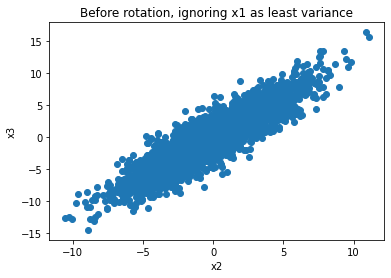

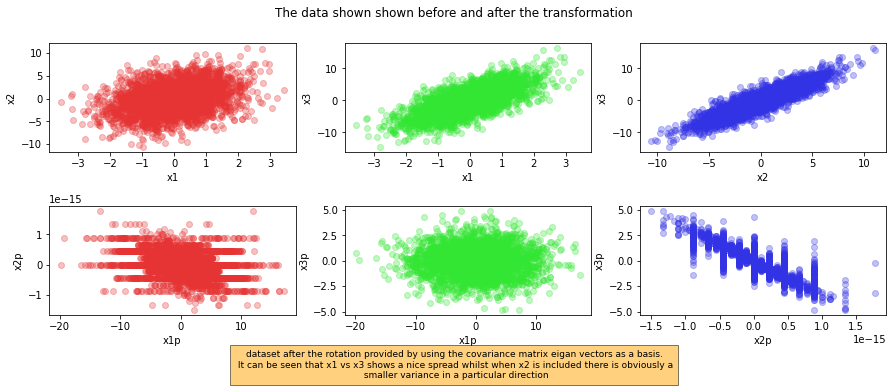

looking at the diagonal of the covariance matrix of the new data, I can see that x2p has the smallest variance by an oder of magnitude -31 so will be ignored
[[ 2.64320499e+01 -6.59942427e-16 -5.31663187e-15]
 [-6.59942427e-16  1.87471320e-31 -5.24990493e-16]
 [-5.31663187e-15 -5.24990493e-16  1.95756463e+00]]


The eigan values corresponding to the eigan vectors used in the transformation are repeatedhere
 The first and last are divided by the sum of them all to get the variability kept. [2.64320499e+01 9.46005090e-16 1.95756463e+00]


The percentage of the origional origional variability kept is: 100.0 %

sometimes this is 100% this is because one of the eigan vales is of the order of -16 and so the computer
strugles.
This makes sence because x3 is a linear combination of x1 and x2


In [1]:
import numpy as np
import matplotlib.pyplot as plt

x1 = np.random.normal(loc = 0, scale = 1, size = 3000)
x2 = x1 + np.random.normal(loc = 0, scale = 3, size = 3000)
x3 = (2*x1) + x2


fig1, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize = (15,5))
ax1.scatter(x1,x2, color = (0.9,0.2,0.2,0.3))
ax1.set(xlabel = 'x1', ylabel = 'x2')
ax2.scatter(x1,x3, color = (0.2,0.9,0.2,0.3))
ax2.set(xlabel = 'x1', ylabel = 'x3')
ax3.scatter(x2,x3, color = (0.2,0.2,0.9,0.3))
ax3.set(xlabel = 'x2', ylabel = 'x3')
fig1.suptitle('The data shown shown before and after the transformation')
    
dataset = np.stack([x1,x2,x3],axis = 0)

cov = np.cov(dataset)

print('The covariance matrix is\n',cov,'\n')
print('From looking at the diagonal values it is seen that the first attribute has the least variance \n \
thus the other two are likley the principle components.')
fig2 = plt.figure()
plt.scatter(x2,x3)
plt.title('Before rotation, ignoring x1 as least variance')
plt.xlabel('x2')
plt.ylabel('x3')

val, vec = np.linalg.eig(cov)
print('Eigan values found from linalg.eig')
print(val,'\n\n')
print('Eigan vectors found from linalg.eig, each column is another eigan vector')
print(vec,'\n\n')

U, spec, Vt = np.linalg.svd(dataset)
svdval = spec**2/(len(x1)-1)

print('Eigan vectors found from linalg.svd, each column is another eigan vector\n \
They are in a different order but they are the same. This is the U matrix from the noatation.\n')
print(U,'\n\n')

print('Eigan values found from linalg.svd\n \
There is two the same and one slightly different')
print(svdval,'\n\n')

print('these are similar to the eigan vectors. This is the Vt matrix from the notation.')
print(Vt,'\n\n')
#ctc = cov.dot(cov.T)
#cct = (cov.T).dot(cov)

#rotate the data based on the eigan vectors
X = np.stack((x1,x2,x3), axis = 0)
Xp = np.dot(vec.T,X)
x1p = Xp[0,:]
x2p = Xp[1,:]
x3p = Xp[2,:]

plt.figure(fig1.number)
ax4.scatter(x1p,x2p, color = (0.9,0.2,0.2,0.3))
ax4.set(xlabel = 'x1p', ylabel = 'x2p')
ax5.scatter(x1p,x3p, color = (0.2,0.9,0.2,0.3))
ax5.set(xlabel = 'x1p', ylabel = 'x3p')
ax6.scatter(x2p,x3p, color = (0.2,0.2,0.9,0.3))
ax6.set(xlabel = 'x2p', ylabel = 'x3p')
plt.figtext(0.5, -0.05,'dataset after the rotation provided by using the covariance matrix eigan vectors as a basis.\n \
It can be seen that x1 vs x3 shows a nice spread whilst when x2 is included there is obviously a\n \
smaller variance in a particular direction', ha="center", fontsize=9, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
plt.subplots_adjust(hspace = 0.5)
plt.show()

covp = np.cov(Xp)
print('looking at the diagonal of the covariance matrix of the new data, I can see that x2p has the smallest variance by an oder of magnitude -31 so will be ignored')
print(covp)

#fig4 = plt.figure()
#plt.scatter(x1p,x3p)
#plt.xlabel('x1p')
#plt.ylabel('x3p')

##to find how much of the variance is kept we look at the ratio of the sums of the eigan values for the kept components and all the components
varKept = (val[0]+val[2])/sum(val)
print('\n\nThe eigan values corresponding to the eigan vectors used in the transformation are repeatedhere\n \
The first and last are divided by the sum of them all to get the variability kept.',val)
print('\n\nThe percentage of the origional origional variability kept is:', varKept*100,'%\n\n\
sometimes this is 100% this is because one of the eigan vales is of the order of -16 and so the computer\n\
strugles.')

print('This makes sence because x3 is a linear combination of x1 and x2')




2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

The eigan values are:
 [2.74942500e+01 2.03577328e+00 3.24351054e-02 2.62296750e-02
 1.98178846e-02 1.44899764e-02 9.86792711e-03 6.38322343e-03
 3.51671621e-03 1.63564568e-03 3.96351009e-04 1.03315478e-29]

The eigan vectors are:
 [[-1.18046387e-01  5.65147302e-01 -1.55810270e-04 -1.13703428e-03
   1.22012061e-03  9.34868745e-04 -8.77061433e-04 -1.13215434e-04
  -1.56251971e-03  7.18146305e-07  8.71979585e-05  8.16496581e-01]
 [-5.74122134e-01 -7.09722159e-01  2.80353745e-04  1.61088944e-03
  -1.55362418e-03 -7.75639331e-04  9.51174649e-04 -3.33056053e-05
   2.22261247e-03 -5.99278710e-05 -1.66256449e-04  4.08248290e-01]
 [-8.10214908e-01  4.20572445e-01 -3.12667960e-05 -6.63179130e-04
   8.86617044e-04  1.09409816e-03 -8.02948216e-04 -2.59736474e-04
  -9.02426951e-04 -5.84915784e-05  8.13946836e-06 -4.08248290e-01]
 [-7.54395206e-05 -1.60814883e-04  2.41887882e-03  3.90883052e-04
   1.28141764e-03  1.19440060e-03 -1.83089781e-04 -7.02500576e-03
   5.13834797e-03  1.82662306e-02  9.99

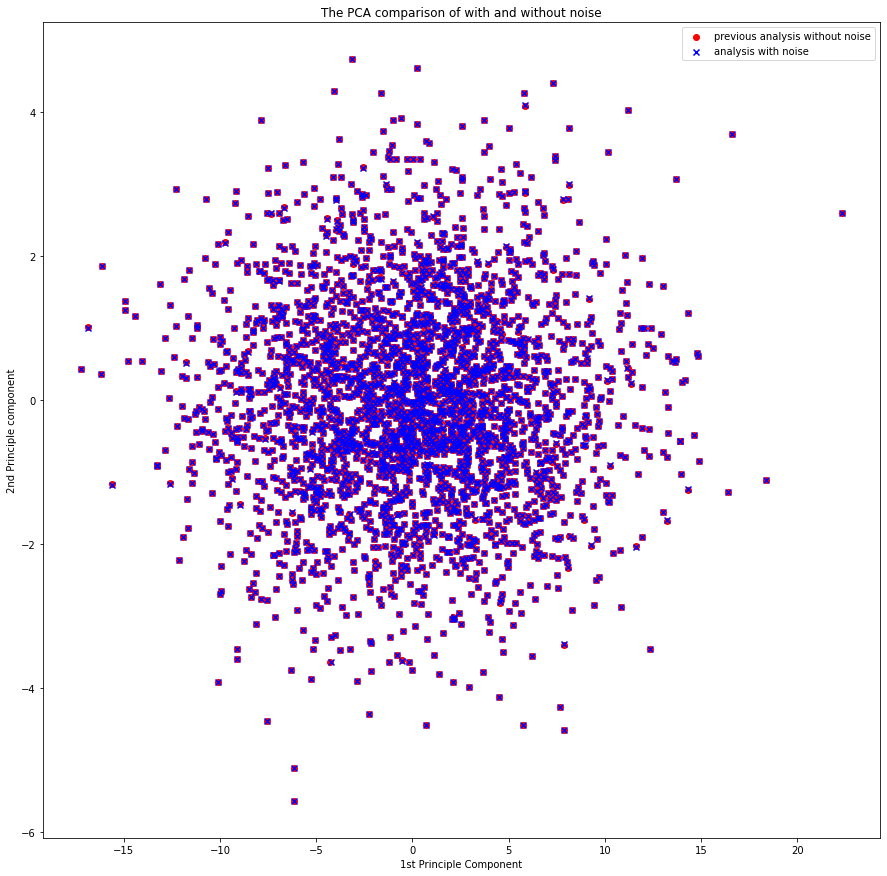

In [36]:
x4 = np.random.normal(loc = 0, scale = (1/50), size = 3000)
x5 = np.random.normal(loc = 0, scale = (2/50), size = 3000)
x6 = np.random.normal(loc = 0, scale = (3/50), size = 3000)
x7 = np.random.normal(loc = 0, scale = (4/50), size = 3000)
x8 = np.random.normal(loc = 0, scale = (5/50), size = 3000)
x9 = np.random.normal(loc = 0, scale = (6/50), size = 3000)
x10 = np.random.normal(loc = 0, scale = (7/50), size = 3000)
x11 = np.random.normal(loc = 0, scale = (8/50), size = 3000)
x12 = np.random.normal(loc = 0, scale = (9/50), size = 3000)

X = np.stack((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12), axis = 0)

U, spec, Vt = np.linalg.svd(X)
val = spec**2/(len(x1)-1)
max1 = np.unique(val)[-1]
max2 = np.unique(val)[-2]

#performaing the rotation
Xp = np.dot(U.T,X)

X1p = Xp[0]
X2p = Xp[1]

secPCA = plt.figure(figsize = (15,15))
plt.scatter(x1p,x3p,label = 'previous analysis without noise', color = 'r')
plt.scatter(X1p,X2p,label = 'analysis with noise', marker = 'x', color = 'b')
plt.xlabel('1st Principle Component')
plt.ylabel('2nd Principle component')
plt.title('The PCA comparison of with and without noise')
plt.legend()

print('The eigan values are:\n',val)

print('\nThe eigan vectors are:\n',U)

print('\nThe max 2 eigan values are:', max1,max2)

varKept = (max1+max2)/sum(val)
print('The percentage of variance kept when using these eigan vectors as priciple components is:',varKept*100,'%')

print('The percentage of variance kept has dropped a little. Althoug it is clear that these noisy dimensions are not needed to represent the data. This is because they only have a small variance when compaired to the initialy defined dimensions.')

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 